<a href="https://colab.research.google.com/github/MalikAsadAftab/Seoul-Bike-Renting-Synthetic-Data-Generation/blob/main/Seoul_Bike_Renting_Synthetic_Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'seoulbikedata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4950435%2F8335660%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240508%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240508T132054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D06ffe6fba5ef09b9f67331a0e510eb3bd1d957af73b9379ee6db18eb894ca7b591963c749cbe2dbf4e8ab1aa6e1930f1bbad7a7b34dce2b5b523478eca7ca35a0db9e9dc63344a22f3883352918431a39846d25fb76fbd8c340b042595bd72dad3fe156b20359c278f5618fcd1f3902a052380dc2ad719f55f38c279df481254cb8dc79e503db00c33bd4a1319bf5a3789f1f70d03f9b9786dcf3e1c079ccb4239e4de6eaa29d2d230caa31d8546cc12ad3019d645f094939299e18332d1cf7a0444c0163b7ac58672a5affb7d8372bcd5026f1906f1cd3f57408d134390435cfa5df723400f0a2ac1dc8a707b9c7dabf420fe0060510d9f124904f97b544d3d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 128783 bytes downloaded
Downloaded and uncompressed: seoulbikedata
Data source import complete.


# **1. Importing Libraries & Data**
First we need to install the [SDV](https://docs.sdv.dev/sdv/installation) package. Then we will import some libraries that we will be using throughout our implementation.

In [2]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 946.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 886.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 19.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Us

In [3]:
# Import necessary libraries
!pip install xgboost
!pip install lightgbm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sdv.datasets.local import load_csvs
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score
from sklearn import preprocessing, linear_model
from sklearn.preprocessing import  LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn import tree
import xgboost as xgb
from xgboost import plot_importance
from lightgbm import LGBMRegressor



import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

### *1.1 Data Loading*

We can now create a Pandas dataframe using the downloaded file, to view and analyze the data.

In [4]:
datasets = load_csvs(
    folder_name='/kaggle/input/seoulbikedata/', #Add the address of the folder where the dataset resides
    read_csv_parameters={
        'skipinitialspace': True,
        'encoding': 'unicode_escape'
    })

# the data is available under the file name
data = datasets['SeoulBikeData']

### *1.2 Data Diagnosis*

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


### *1.3 Data Duplicate Check*

In [6]:
# Check for duplicated entries.
print("Duplicate entry in data:",len(data[data.duplicated()]))
data = data.drop_duplicates()

Duplicate entry in data: 0


# **2. Feature Engineering:**

First we analyze the data in order to clean it and then feed it to synthesizer to generate data.

### *2.1_Rented Bike days Filtering*
Checking number of bikes rented against number of hours on functional and non funtioning day. Because if its not functioning then this feature in the dataset doesnot make any sense.

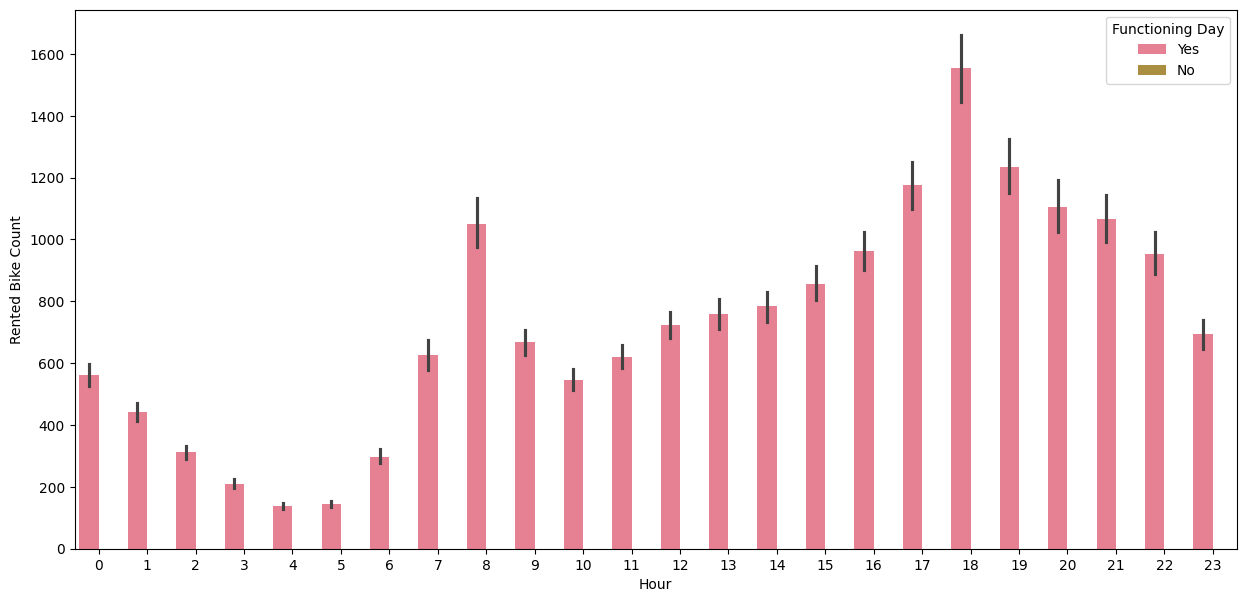

In [7]:
#for chech functioning and non functioning day ,plot (Hour Vs Rented Bike Count Graph)
def barplots(x,y,hue):
    plt.figure(figsize=(15,7))
    sns.set_palette("husl")
    sns.barplot(x=x,y=y,hue=hue,data=data);
barplots('Hour','Rented Bike Count','Functioning Day')

In [8]:
# Grouping by functioning day and calculating the total Rented Bike Count
data.groupby('Functioning Day').sum()['Rented Bike Count'].sort_values(ascending = False).reset_index()

,Functioning Day,Rented Bike Count
0,Yes,6172314
1,No,0


As per diagnosis data found that rental bike only given on Functioning Day, so remove Non Functioning Days and then remove Functioning Day Column.

In [9]:
#Removing data of non functional days (non rented days)
df=data.drop(data[data['Functioning Day'] == 'No'].index)

In [10]:
#Due to not unsefull in Functioning Day Column ,remove Functioning Day Column
df1=df.drop(['Functioning Day'], axis = 1)

In [11]:
#Checking DataFrame Shape After Removing Non Functional Day Rows And Functional Day Column
print("Filtered Dataframe with only rented bike days :",df1.shape,"\n")

Filtered Dataframe with only rented bike days : (8465, 13) 



### *2.2 Seperate Date, Month, Year from Date Column*

First, let's convert `Date` to a `datecolumn` and extract different parts of the date, as it will help us to filter the data more and find more insights from the dataset.

In [12]:
df1['Date']=pd.to_datetime(df1['Date'], errors='coerce', format='mixed')

In [13]:
#Seperate Day, Month, Year from DataFrame Column

df1['Day']=df1['Date'].dt.day
df1['Month']=df1['Date'].dt.month
df1['Year']=df1['Date'].dt.year

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8465 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8465 non-null   datetime64[ns]
 1   Rented Bike Count          8465 non-null   int64         
 2   Hour                       8465 non-null   int64         
 3   Temperature(°C)            8465 non-null   float64       
 4   Humidity(%)                8465 non-null   int64         
 5   Wind speed (m/s)           8465 non-null   float64       
 6   Visibility (10m)           8465 non-null   int64         
 7   Dew point temperature(°C)  8465 non-null   float64       
 8   Solar Radiation (MJ/m2)    8465 non-null   float64       
 9   Rainfall(mm)               8465 non-null   float64       
 10  Snowfall (cm)              8465 non-null   float64       
 11  Seasons                    8465 non-null   object        
 12  Holiday    

In [15]:
# drop the Date column after extracting necessory information
df1.drop(columns=['Date'],inplace=True)

In [16]:
df1

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day,Month,Year
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018


## **3. Exploratory Analysis and Visualization**

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "Rented Bike count" and other columns, as "Rented Bike count" is the key feature.


> We'll use libraries ***Matplotlib***, ***Seaborn*** for visualization.


### *3.1 _ Checking Correlation Of Data*

Correlation is a statistical measure that expresses the strength of the relationship between two variables.

The two main types of correlation : ***positive and negative.***

*   ***Positive correlation*** occurs when two variables move in the same direction; as one increases, so do the other.
*   ***Negative correlation*** occurs when two variables move in opposite directions; as one increases, the other decreases.

Correlation can be used to test hypotheses about cause and effect relationships between variables. Correlation is often used in the real world to predict trends.

In [17]:
numeric_data = df1.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
data_corr = numeric_data.corr()

<Axes: >

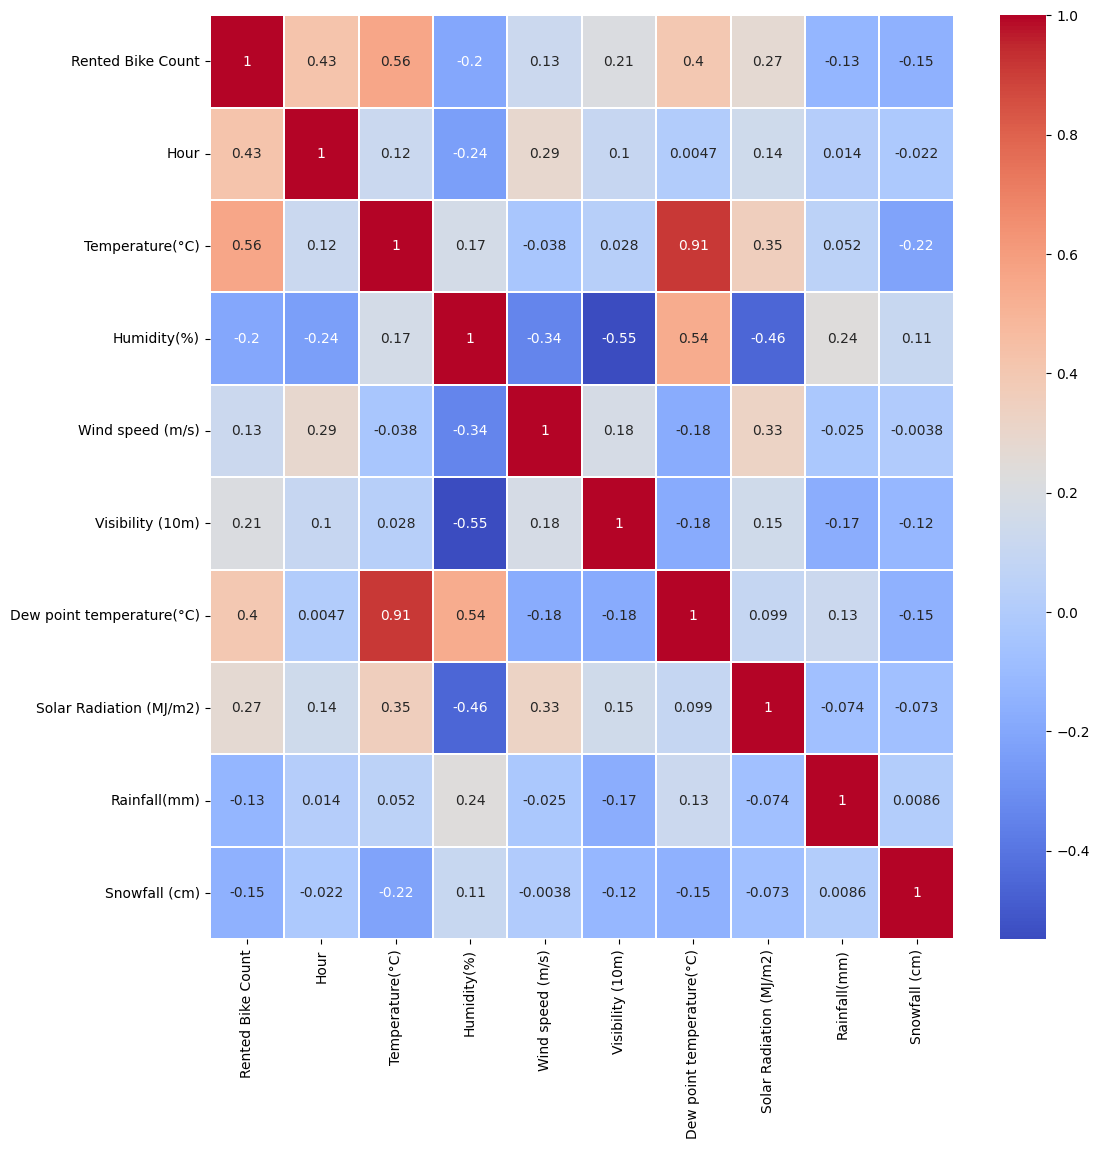

In [18]:
plt.figure(figsize=(12,12))

#cmap use for colour palette , linewidths : set the width of the lines that divide the cells,
#annot :helps in annotating the heatmap with values if set to True, otherwise values are not provided , linecolor : helps in setting the color of each line that divides heatmap cells
sns.heatmap(data_corr, cmap='coolwarm', linewidths=0.1, annot=True, linecolor='white')

***Temperature (°C)*** and ***Dew point temperature (°C)*** are almost ***0.91*** correlated, So it's generate multicollinearity issue. Also ***Dew point temperature (°C)*** has ***0.54*** correlation with ***Humidity (%)***.



> So, we drop ***Dew point temperature (°C)*** feature



In [19]:
#Drop Dew point temperature(°C) from dataset df1
df1.drop(columns=['Dew point temperature(°C)'],inplace=True)

### *3.2 Seperate Numerical And Categorical Variables*


*   ***Categorical data*** is a type of data that is used to group information with similar characteristics
*   ***Numerical data*** is a type of data that expresses information in the form of numbers.






#### **Numarical Variables**

In [20]:
#if dtype is not Equal to object type then its a num data
numerical_features=[col for col in df1.columns if df1[col].dtype!='O']
numerical_features

['Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Day',
 'Month',
 'Year']

In [21]:
# Seprate dataframe for Numerical feature
num_data=df1[numerical_features]
num_data

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Day,Month,Year
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,12,1,2017
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,12,1,2017
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,12,1,2017
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,12,1,2017
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,12,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,0.0,0.0,0.0,30,11,2018
8756,764,20,3.4,37,2.3,2000,0.0,0.0,0.0,30,11,2018
8757,694,21,2.6,39,0.3,1968,0.0,0.0,0.0,30,11,2018
8758,712,22,2.1,41,1.0,1859,0.0,0.0,0.0,30,11,2018


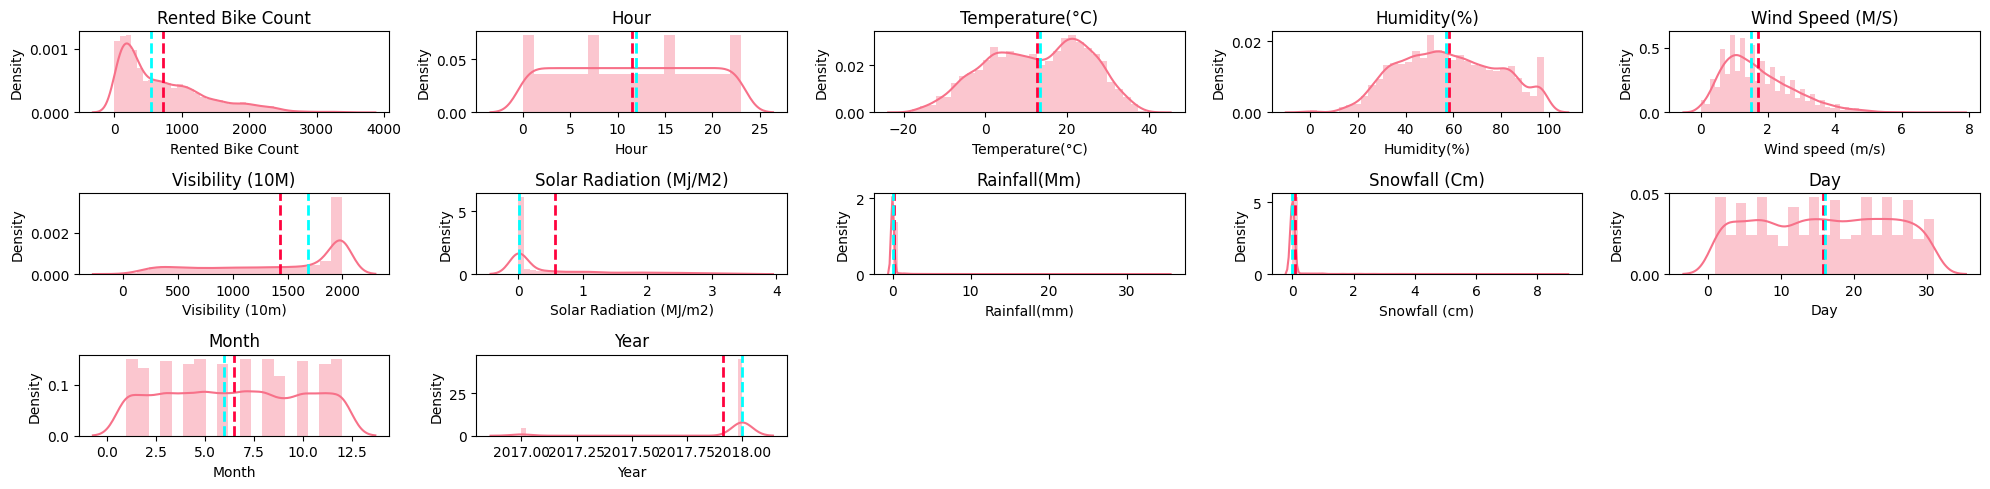

In [22]:
#plot num data to analysis data distribution
fig = plt.figure(figsize = (20,5))
for index,column in enumerate(numerical_features) :
  plt.subplot(3,5,index+1)
  sns.distplot(df1[column])
  feature = df1[column]
  ax = fig.gca()
  ax.axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=2)  #Rose-Red Color indicate mean of data
  ax.axvline(feature.median(), color='#00ffff', linestyle='dashed', linewidth=2) #Cyan indicate median of data
  plt.title(f'{column.title()}')
  plt.tight_layout()




*   ***Right/Positive Skewed Distribution*** (Mode < Median < Mean): Rented Bike Count, Wind Speed(m/s), Solar Radiation(MJ/m2)
*   ***No Skew*** (Mean = Median = Mode) : Hour, Temperature, Humidity(%),Rainfall(mm), Snowfall(cm)
*   ***Left/Negative Skewed Distribution*** (Mean < Median < Mode): Visibility(10M)




Discrete Variables Count: 4


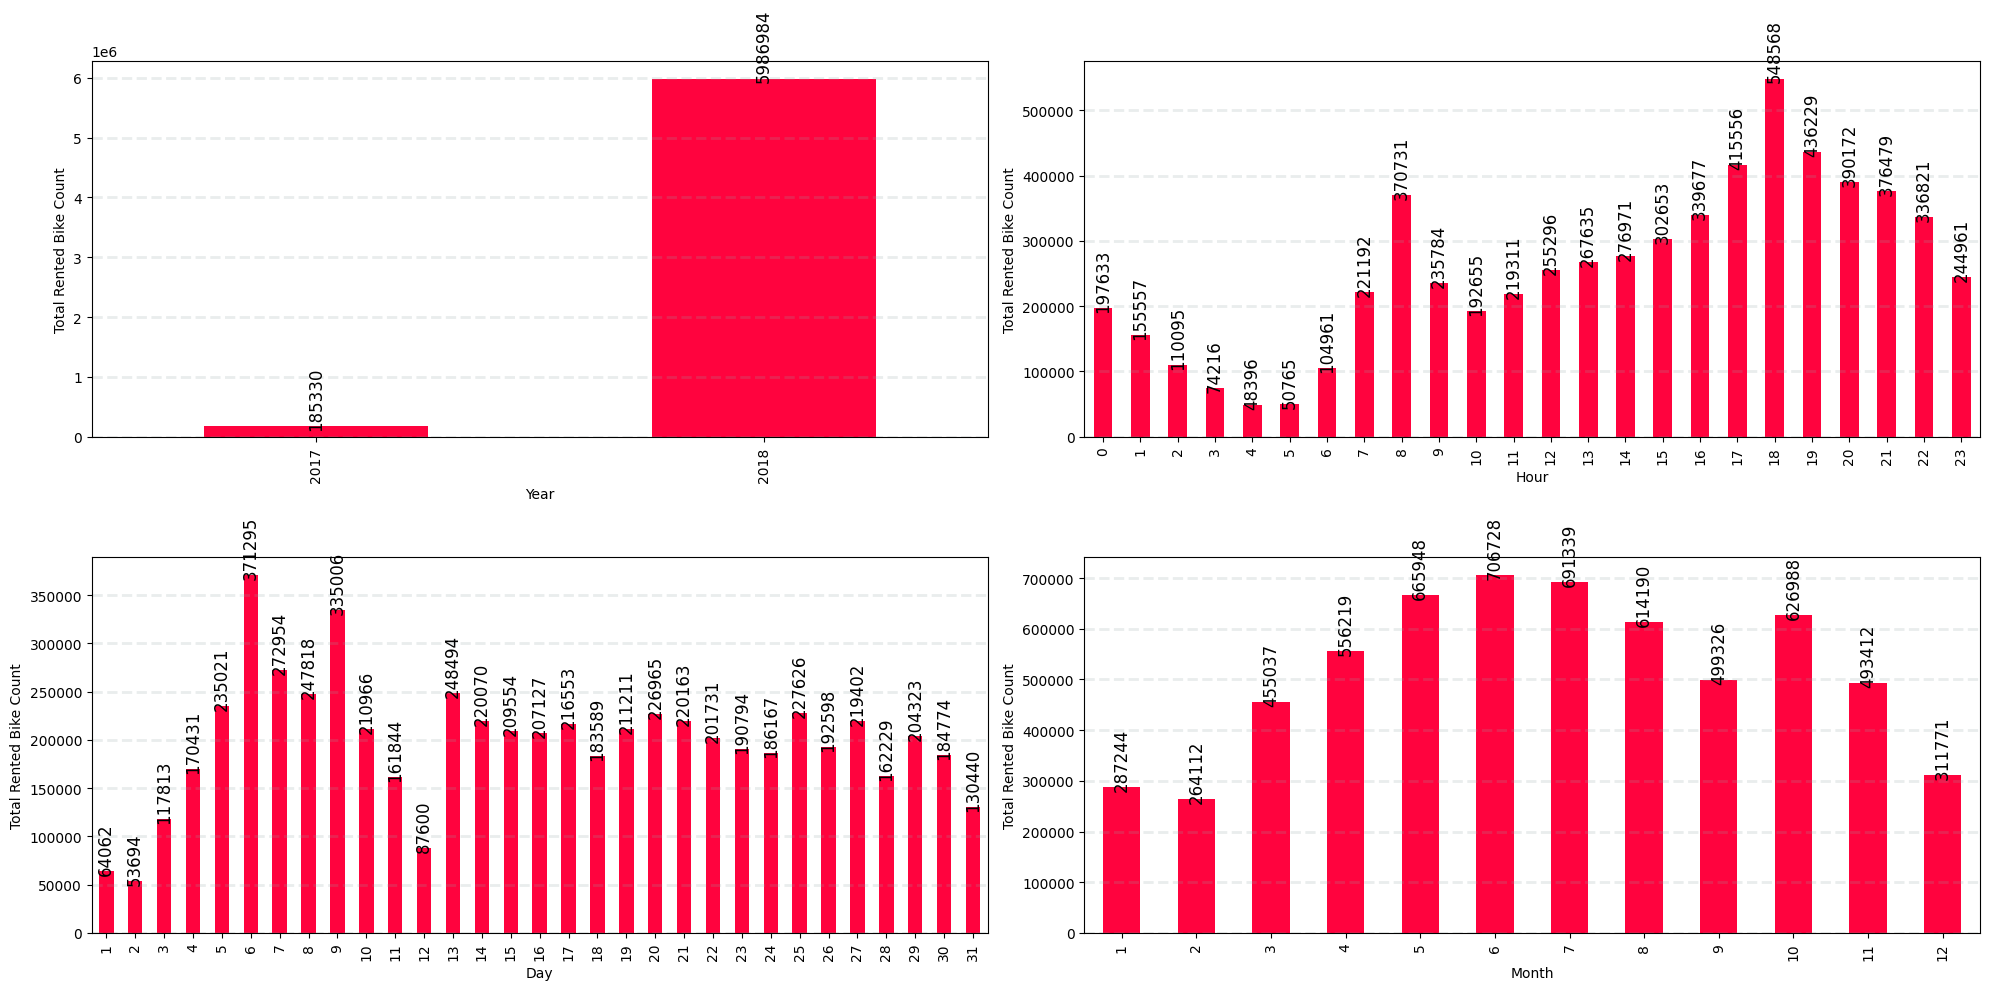

In [23]:
## Lets analyse the discrete values by creating histograms to understand the distribution
num_discrete_value=[feature for feature in numerical_features if len(df1[feature].unique())<32]
print("Discrete Variables Count: {}".format(len(num_discrete_value)))

fig = plt.figure(figsize = (20,10))
for index,column in enumerate(num_discrete_value) :
  plt.subplot(2,2,index+1)
  dataset=df1.copy()
  dataset.groupby(feature)['Rented Bike Count'].sum().plot(kind='bar',color="#ff033e") #kind=bar use for ploting barchart
  feature = df1[column]
  ax = fig.gca()
  plt.ylabel('Total Rented Bike Count')
  plt.tight_layout()
  plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
  for p in ax.patches:
      ax.annotate(round(p.get_height()),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 12, rotation=90) #ha use to write count in center and rotation use to rotate count to 90 degree and make clear visible on graph

#### **Categorical Variables**

In [24]:
#For categorical Data
categorical_features=[col for col in df1.columns if df1[col].dtype=='O']
categorical_features

['Seasons', 'Holiday']

In [25]:
# Seprate dataframe for Categorical feature
cat_data=df1[categorical_features]

In [26]:
# Unique number of categorical features
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(data[feature].unique())))

The feature is Seasons and number of categories are 4
The feature is Holiday and number of categories are 2


In [27]:
# GROUPING BY SEASONS AND CALCULATING THE TOTAL RENTED BIKE COUNT
data.groupby('Seasons').sum()['Rented Bike Count'].sort_values(ascending = False).reset_index()

,Seasons,Rented Bike Count
0,Summer,2283234
1,Autumn,1790002
2,Spring,1611909
3,Winter,487169


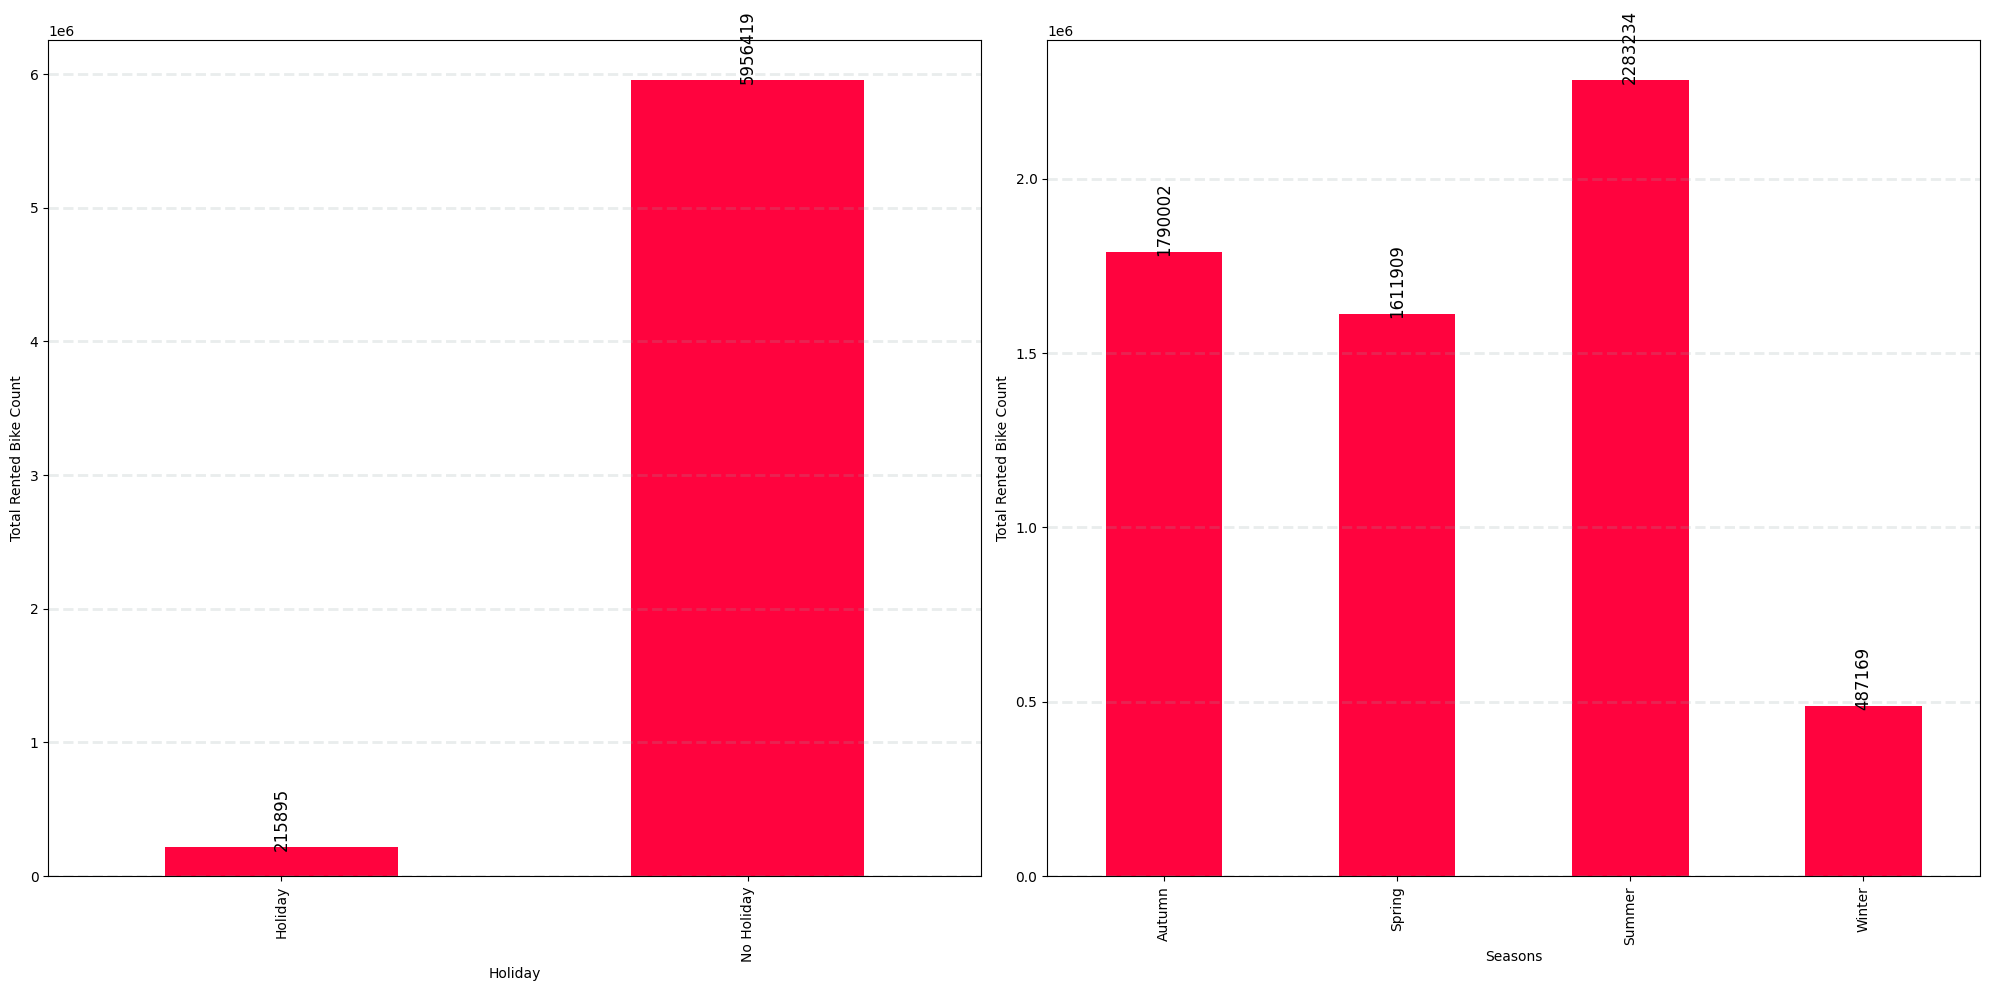

In [28]:
#Find out the relationship between categorical variable and dependent feature Rented Bike Count

fig = plt.figure(figsize = (20,10))
for index,column in enumerate(categorical_features) :
    plt.subplot(1,2,index+1)
    dataset=df1.copy()
    dataset.groupby(feature)['Rented Bike Count'].sum().plot(kind='bar',color="#ff033e")
    feature = df1[column]
    ax = fig.gca()
    plt.ylabel('Total Rented Bike Count')
    plt.tight_layout()
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
    for p in ax.patches:
        ax.annotate(round(p.get_height()),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 12, rotation=90)


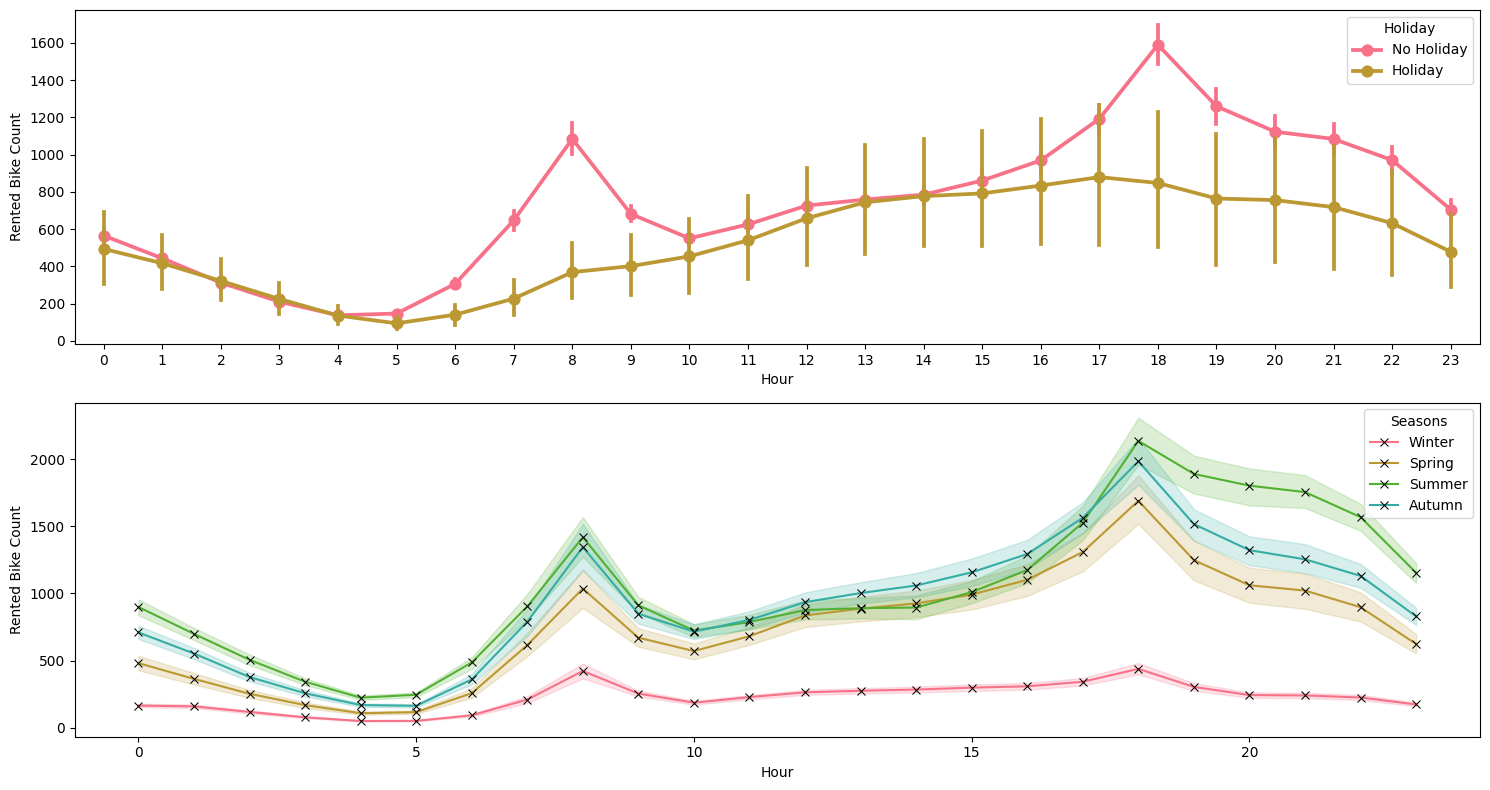

In [29]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(15,8), dpi=100)
sns.pointplot(data=dataset, x="Hour", y="Rented Bike Count", ax=axs[0],
              hue="Holiday")
sns.lineplot(data=dataset, x="Hour", y="Rented Bike Count", ax=axs[1],
              hue="Seasons", marker="x",markeredgecolor="black")
plt.tight_layout()

### *3.3 Encoding Data*

Encoding categorical data can be done into different ways:
1. oh_df : OneHotEncoder Data
2. le_df : LabelEncoder Data

One-hot encoding approach eliminates the order but it causes the number of columns to expand vastly. So for columns with more unique values try using other techniques like ***Label Encoding***.

In [30]:
# Encode labels of multiple columns at ones using LabelEncoder
le_df= df1.apply(LabelEncoder().fit_transform)
le_df

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day,Month,Year
0,252,0,111,28,22,1779,0,0,0,3,1,11,0,0
1,202,1,108,29,8,1779,0,0,0,3,1,11,0,0
2,171,2,103,30,10,1779,0,0,0,3,1,11,0,0
3,105,3,101,31,9,1779,0,0,0,3,1,11,0,0
4,76,4,103,27,23,1779,0,0,0,3,1,11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,990,19,205,25,26,1673,0,0,0,0,1,29,10,1
8756,754,20,197,28,23,1779,0,0,0,0,1,29,10,1
8757,685,21,189,30,3,1747,0,0,0,0,1,29,10,1
8758,703,22,184,32,10,1639,0,0,0,0,1,29,10,1


Checking Season Coloumn Data

In [31]:
df1.groupby("Seasons").count()  #for checking raw data

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Day,Month,Year
Seasons,,,,,,,,,,,,,
Autumn,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937
Spring,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160
Summer,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208
Winter,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160


In [32]:
le_df.groupby('Seasons').count() #Seasons convert to numerical after apply transformation on data

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Day,Month,Year
Seasons,,,,,,,,,,,,,
0,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937
1,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160
2,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208
3,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160


0 : Autumn , 1 : Spring , 2 : Summer , 3 : Winter

### **Checking Ditrubutation and Outliner on DataFrame**

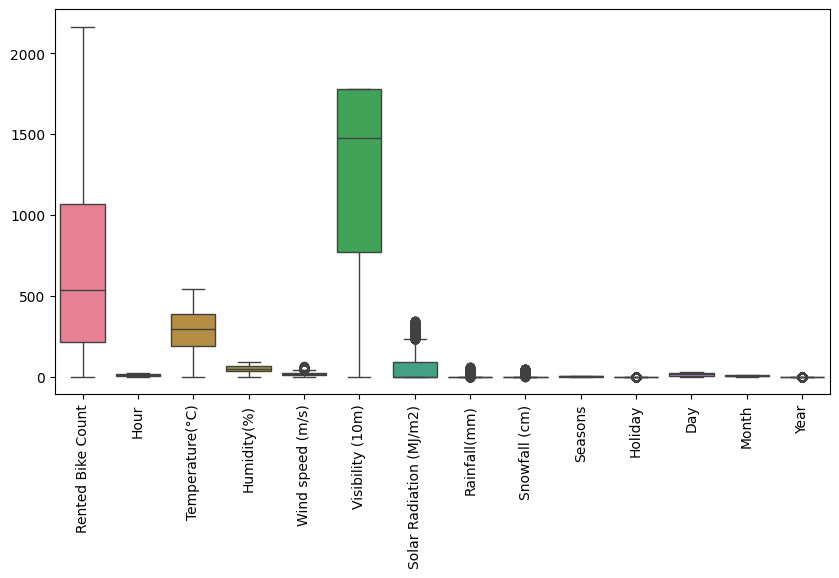

In [33]:
#checking for outliers
plt.figure(figsize=(10,5))   # for define chart size
plt.xticks(rotation =90)     #plot X-axis ticks in 90 degree rotation for clear visible
sns.boxplot(data = le_df)    #box plot of le_df data frame raw data
plt.show()

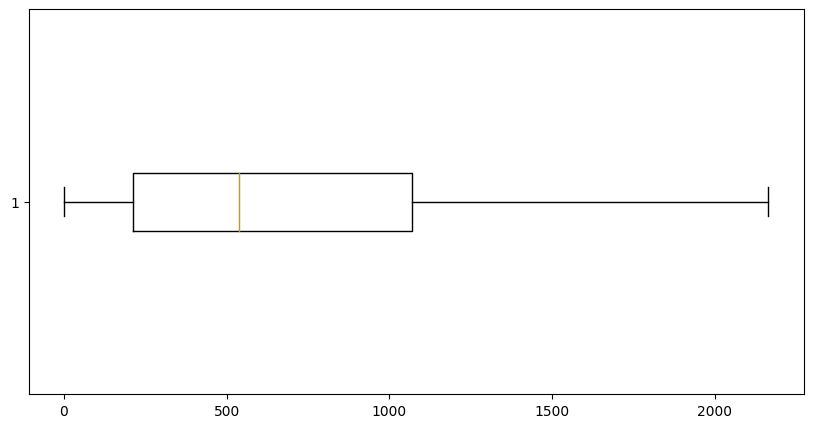

In [34]:
plt.figure(figsize=(10,5))
plt.boxplot(le_df['Rented Bike Count'],vert=False)
plt.show()

## **4. Synthetic Data Generation**

- The column ***Rented Bike Count*** contains the value we need to predict i.e. it's the target column.
- Data from all the other columns (except the first and the last column) can be used as inputs to the model.


In [35]:
X=le_df.drop('Rented Bike Count',axis=1)
y=le_df['Rented Bike Count']

### *4.1 Spliting Training and Testing Set*
Finally, let's split the dataset into a **training** and **testing** set.

We'll use a randomly select *80%* subset of the data for **training**. Also, we'll use just the numeric and encoded columns.

Throught the **training** set we will generate **synthetic** data of the same length.

The remaining *20%* will be used to test **models** trained separately on **original** and **synthetic data**.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
df_remaining=pd.concat([X_train, y_train], axis=1)

In [38]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

### **Auto detect Metadata**

Automatically detect the metadata based on your actual data. Different methods are available based on the format of your data.

In [39]:
metadata.detect_from_dataframe(df_remaining)

### **Inspection API**

At any point, you can inspect the current state of the metadata.

In [40]:
python_dict = metadata.to_dict()

### **Visualize**

To visual represent the number of columns that are categrical and number of columns that are numerical.

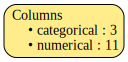

In [41]:
metadata.visualize(
    show_table_details='summarized',
    output_filepath='my_metadata.png'
)

### **Validate**
Use this to validate that the metadata is written according to the specification

In [42]:
metadata.validate()

### **Modeling Synthesizer**
When creating your synthesizer, you are required to pass in a ***SingleTableMetadata*** object as the first argument. All other parameters are optional. You can include them to customize the synthesizer.

In [43]:
from sdv.single_table import GaussianCopulaSynthesizer,TVAESynthesizer

synthesizer = TVAESynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=True,
    epochs=500
)

#fit the original set
synthesizer.fit(df_remaining)


#Samples Generation
synthetic_data = synthesizer.sample(num_rows=len(df_remaining))

### **Loss**

To view the loss between at each epoch of training and batch of Input.

In [44]:
synthesizer.get_loss_values()

,Epoch,Batch,Loss
0,0,0,65.329437
1,0,1,58.534607
2,0,2,54.742668
3,0,3,52.080521
4,0,4,51.817360
...,...,...,...
6995,499,9,-18.429026
6996,499,10,-18.820404
6997,499,11,-18.652445
6998,499,12,-18.506245


In [45]:
synthesizer.auto_assign_transformers(data)

In [46]:
synthesizer.get_transformers()

{'Hour': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Temperature(°C)': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Humidity(%)': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Wind speed (m/s)': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Visibility (10m)': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Solar Radiation (MJ/m2)': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Rainfall(mm)': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Snowfall (cm)': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Seasons': None,
 'Holiday': None,
 'Day': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Month': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'Year': None,
 'Rented Bike Count': FloatFormatter(learn_rounding

### **Diagnostic & Data Quality**
The Diagnostic Report runs some basic checks for data format and validity. Run this to ensure that you have created valid synthetic data.

In [47]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(df_remaining, synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(df_remaining, synthetic_data, metadata)



Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 518.97it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 119.77it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 190.02it/s]|
Column Shapes Score: 94.0%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:03<00:00, 29.99it/s]|
Column Pair Trends Score: 61.46%

Overall Score (Average): 77.73%



### **Visulization**
Use these functions to visualize your actual data in 1 or 2-dimensional space. This can help you see what kind of patterns the synthetic data has learned, and identify differences between the real and synthetic data.

In [48]:
# 3. plot the data
fig = get_column_plot(
    real_data=data,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='Rented Bike Count'
)

fig.show()

Now, comparing the skewness property and also viewing the difference between its distribution

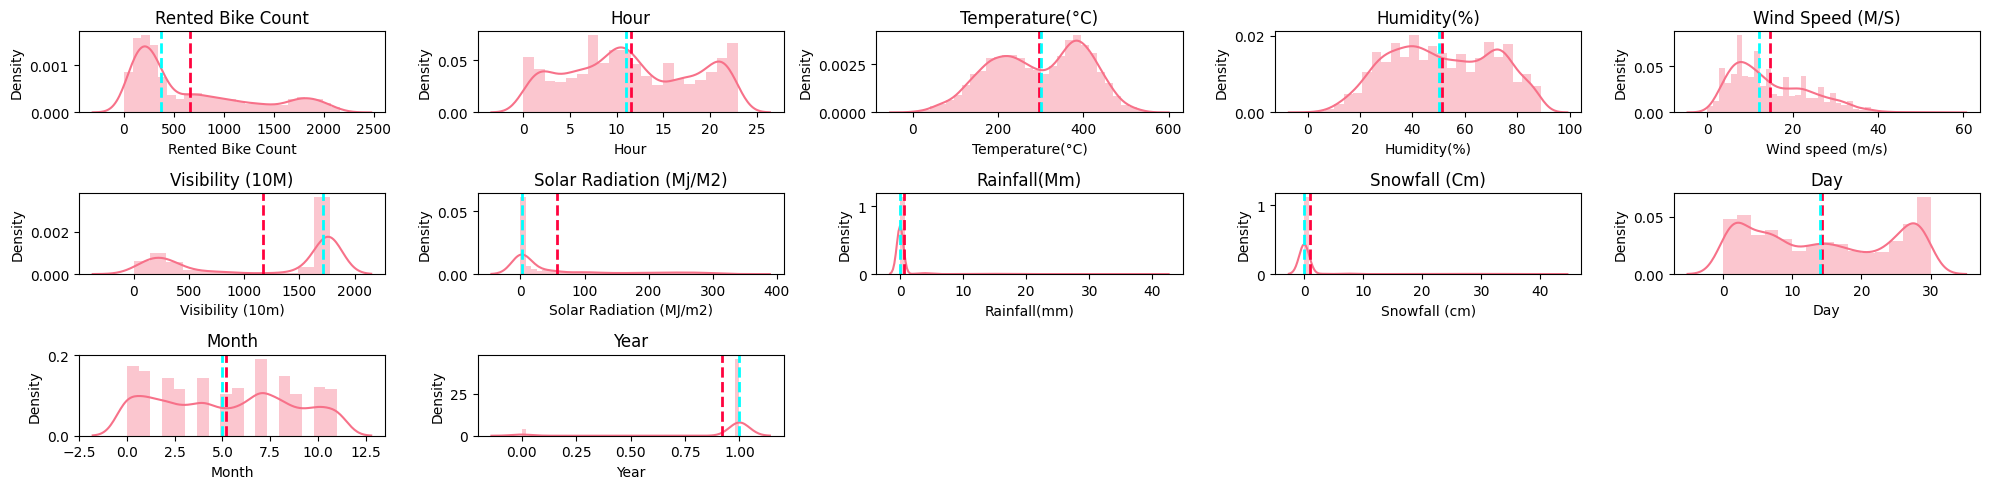

In [49]:
#plot num data to analysis data distribution
fig = plt.figure(figsize = (20,5))
for index,column in enumerate(numerical_features) :
  plt.subplot(3,5,index+1)
  sns.distplot(synthetic_data[column])
  feature = synthetic_data[column]
  ax = fig.gca()
  ax.axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=2)  #Rose-Red Color indicate mean of data
  ax.axvline(feature.median(), color='#00ffff', linestyle='dashed', linewidth=2) #Cyan indicate median of data
  plt.title(f'{column.title()}')
  plt.tight_layout()

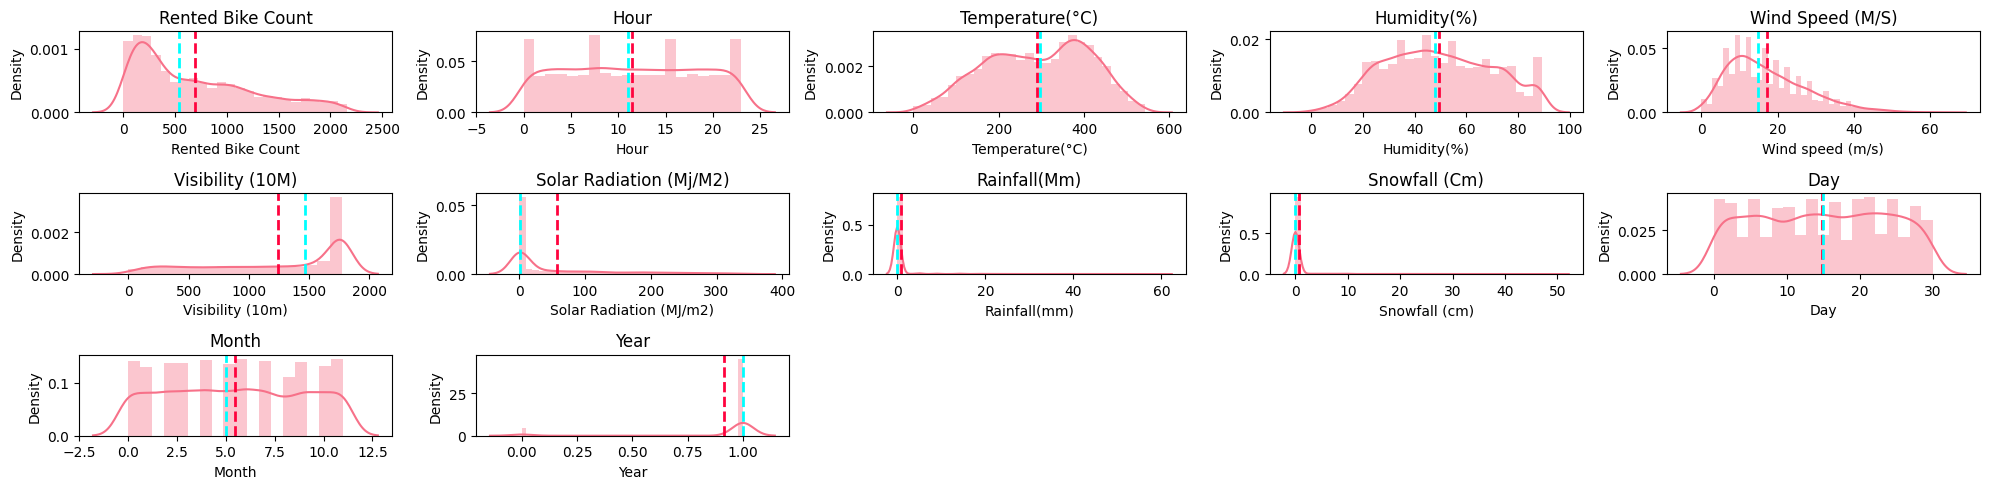

In [50]:
#plot num data to analysis data distribution
fig = plt.figure(figsize = (20,5))
for index,column in enumerate(numerical_features) :
  plt.subplot(3,5,index+1)
  sns.distplot(df_remaining[column])
  feature = df_remaining[column]
  ax = fig.gca()
  ax.axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=2)  #Rose-Red Color indicate mean of data
  ax.axvline(feature.median(), color='#00ffff', linestyle='dashed', linewidth=2) #Cyan indicate median of data
  plt.title(f'{column.title()}')
  plt.tight_layout()

In [51]:
synthetic_data.describe()

,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day,Month,Year,Rented Bike Count
count,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000
mean,11.564530,295.555227,51.362079,14.754725,1166.474158,56.486267,0.607944,1.061872,1.574129,0.999262,14.330774,5.207324,0.919669,665.247785
std,6.637955,109.250755,19.768959,9.028955,717.910311,88.133614,3.071541,5.059374,1.082329,0.027164,9.962869,3.473871,0.271825,607.169985
min,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,207.000000,35.000000,8.000000,310.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,2.000000,1.000000,196.000000
50%,11.000000,301.000000,50.000000,12.000000,1717.000000,3.000000,0.000000,0.000000,2.000000,1.000000,14.000000,5.000000,1.000000,369.000000
75%,17.000000,387.000000,69.000000,21.000000,1775.000000,82.000000,0.000000,0.000000,3.000000,1.000000,25.000000,8.000000,1.000000,1032.000000
max,23.000000,544.000000,89.000000,56.000000,1779.000000,344.000000,41.000000,42.000000,3.000000,1.000000,30.000000,11.000000,1.000000,2164.000000


In [52]:
df_remaining.describe()

,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day,Month,Year,Rented Bike Count
count,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000,6772.000000
mean,11.478884,290.954814,49.335794,17.256497,1239.350561,56.906675,0.883491,0.764324,1.535292,0.950236,14.782782,5.483018,0.913615,693.110012
std,6.898316,120.428605,20.502304,10.336528,572.410381,86.887739,4.588149,4.272609,1.102525,0.217472,8.805362,3.457808,0.280953,570.711624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,194.000000,33.000000,9.000000,764.750000,0.000000,0.000000,0.000000,1.000000,1.000000,7.000000,3.000000,1.000000,212.000000
50%,11.000000,298.000000,48.000000,15.000000,1467.000000,1.000000,0.000000,0.000000,2.000000,1.000000,15.000000,5.000000,1.000000,538.000000
75%,17.000000,389.000000,65.000000,23.000000,1779.000000,93.000000,0.000000,0.000000,3.000000,1.000000,22.000000,9.000000,1.000000,1067.000000
max,23.000000,544.000000,89.000000,64.000000,1779.000000,344.000000,60.000000,50.000000,3.000000,1.000000,30.000000,11.000000,1.000000,2164.000000


### **Save**
Saving dataframes to files in order use them for later work.

In [53]:
output_file = "synthetic_data.csv"

# Write the DataFrame to the new CSV file
synthetic_data.to_csv(output_file, index=False)

In [54]:
output_file_X_test = "X_test.csv"

# Write the DataFrame to the new CSV file
X_test.to_csv(output_file_X_test, index=False)

In [55]:
output_file_y_test = "y_test.csv"

# Write the DataFrame to the new CSV file
y_test.to_csv(output_file_y_test, index=False)

In [56]:
output_file_X_train = "X_train.csv"

# Write the DataFrame to the new CSV file
X_train.to_csv(output_file_X_train, index=False)

In [57]:
output_file_y_train = "y_train.csv"

# Write the DataFrame to the new CSV file
y_train.to_csv(output_file_y_train, index=False)

# **5. Models training**

First we will train on the ***original data*** using different regression techniques.

Then we wil test the model accuracy with ***test set*** separated in **section 4**.

Later we will train the different regression models using ***synthetic data*** and test against the original ***test set***.

## **Original Data First**

**Different Models Accuracy Checking Using Robust Scaler**

In [58]:
def predict(ml_model,X_train,y_train,X_test,y_test):
    rob =RobustScaler()

    X_train = rob.fit_transform(X_train)
    X_test = rob.transform(X_test)

    model=ml_model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    plt.scatter(y_pred,y_test,color='b')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    print(f'R^2 is {model.score(X_test,y_test)}\n Adj R^2 is {1-(1-model.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)}\n RMSE is: {mean_squared_error(y_test,y_pred,squared=False)}')


**R2** shows how well terms (data points) fit a curve or line.
**Adjusted R2** also indicates how well terms fit a curve or line, but adjusts for the number of terms in a model. If you add more and more useless variables to a model, adjusted r-squared will decrease. If you add more useful variables, adjusted r-squared will increase.

**Adjusted R2** will always be less than or equal to **R2**.


**R2** assumes that every single variable explains the variation in the dependent variable.

**The adjusted R2** tells you the percentage of variation explained by only the independent variables that actually affect the dependent variable.

R^2 is 0.5992307630988627
 Adj R^2 is 0.5961277255290505
 RMSE is: 353.97841655492795


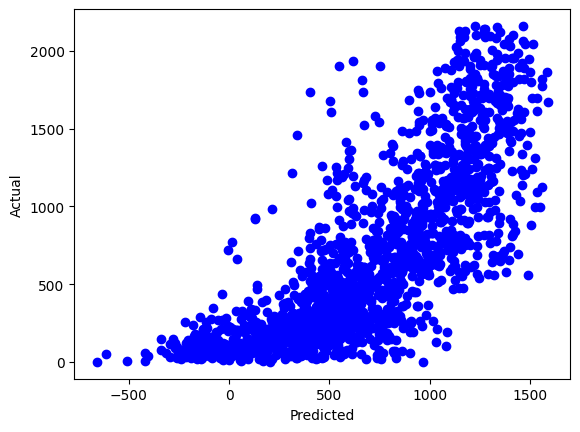

In [59]:
Or_LR = predict(LinearRegression(),X_train,y_train,X_test,y_test)

R^2 is 0.7833303632422974
 Adj R^2 is 0.7816527543811598
 RMSE is: 260.2727021872239


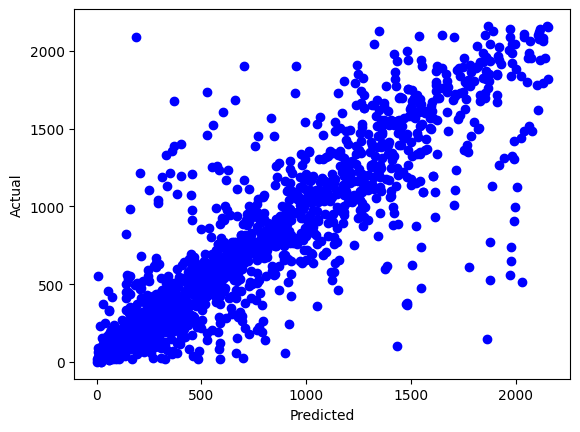

In [60]:
Or_DTR = predict(DecisionTreeRegressor(),X_train,y_train,X_test,y_test)

R^2 is 0.8798205269762169
 Adj R^2 is 0.878890012890863
 RMSE is: 193.84059805398851


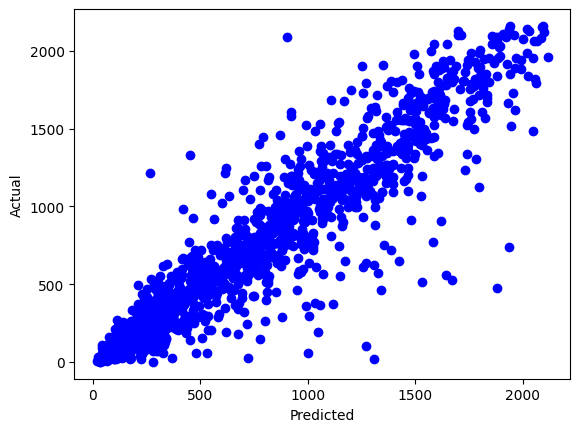

In [61]:
Or_RFR = predict(RandomForestRegressor(),X_train,y_train,X_test,y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 6772, number of used features: 13
[LightGBM] [Info] Start training from score 693.110012
R^2 is 0.8877639365966321
 Adj R^2 is 0.8868949259806441
 RMSE is: 187.32502802820866


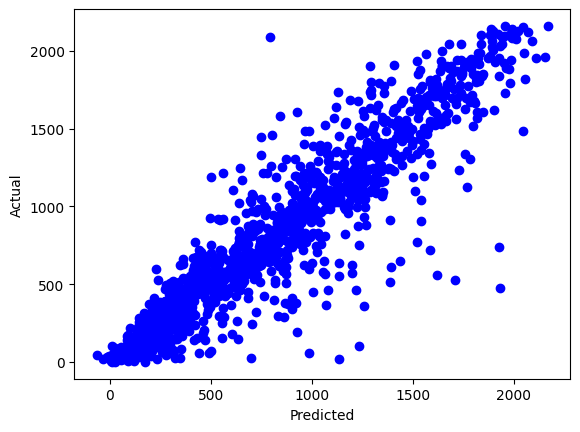

In [62]:
Or_LGBMR = predict(LGBMRegressor(),X_train,y_train,X_test,y_test)

## **Synthetic Data**

In [63]:
X_train_syn=synthetic_data.drop('Rented Bike Count',axis=1)
y_train_syn=synthetic_data['Rented Bike Count']

R^2 is 0.5566763675130999
 Adj R^2 is 0.5532438438547738
 RMSE is: 372.2974271438548


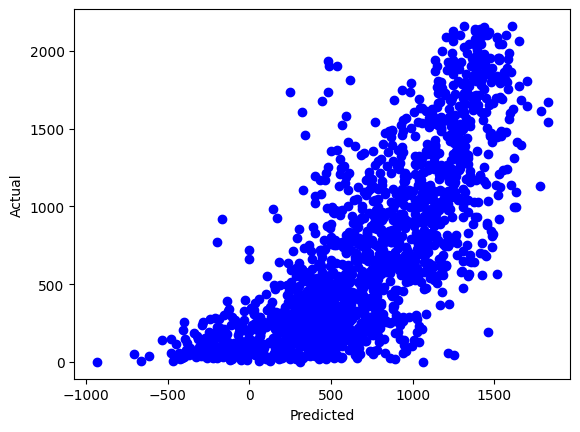

In [64]:
sd_LR = predict(LinearRegression(),X_train_syn,y_train_syn,X_test,y_test)

R^2 is 0.31099428512224725
 Adj R^2 is 0.3056595178242063
 RMSE is: 464.1314583520645


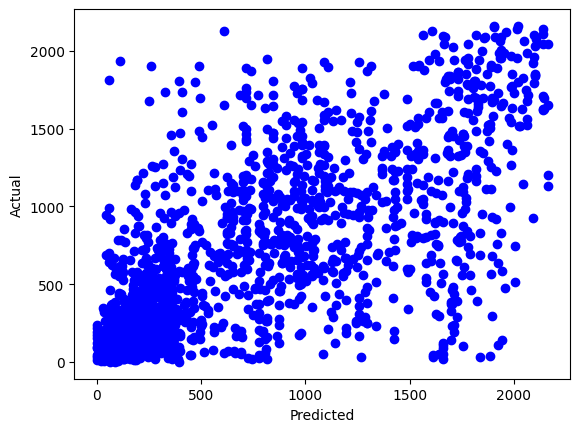

In [65]:
sd_DTR = predict(DecisionTreeRegressor(),X_train_syn,y_train_syn,X_test,y_test)

R^2 is 0.6704767677084573
 Adj R^2 is 0.6679253668628409
 RMSE is: 320.9760386466447


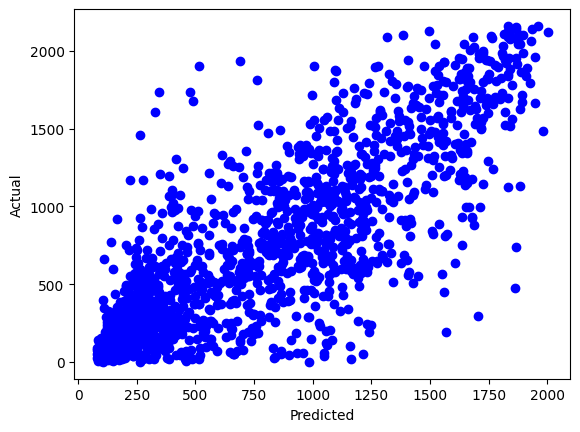

In [66]:
sd_RFR = predict(RandomForestRegressor(),X_train_syn,y_train_syn,X_test,y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 6772, number of used features: 12
[LightGBM] [Info] Start training from score 665.247785
R^2 is 0.711977783868252
 Adj R^2 is 0.7097477131060645
 RMSE is: 300.0838252275809


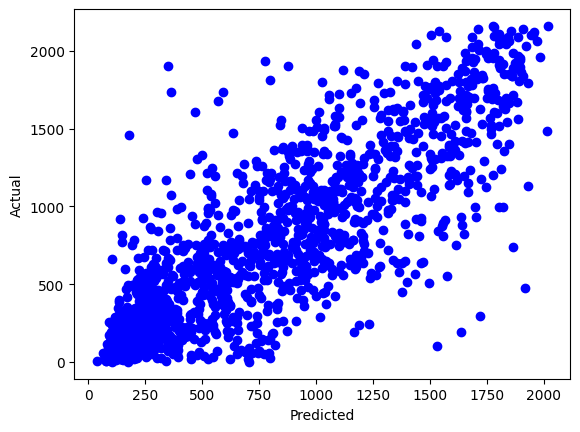

In [67]:
sd_LGBMR = predict(LGBMRegressor(),X_train_syn,y_train_syn,X_test,y_test)

# **6. Comparison**

Now we will compare the ***sythetic data*** with the ***original data***.

## **6.1 Contingency Similarity**
To check similarity of a pair of categorical columns between the real and synthetic datasets -- aka it compares 2D distributions.

In [68]:
from sdmetrics.column_pairs import ContingencySimilarity

ContingencySimilarity.compute(
    real_data=df_remaining[['Hour',	'Temperature(°C)',	'Humidity(%)',	'Wind speed (m/s)',	'Visibility (10m)',	'Solar Radiation (MJ/m2)',	'Rainfall(mm)',	'Snowfall (cm)',	'Seasons',	'Holiday',	'Rented Bike Count']],
    synthetic_data=synthetic_data[['Hour',	'Temperature(°C)',	'Humidity(%)',	'Wind speed (m/s)',	'Visibility (10m)',	'Solar Radiation (MJ/m2)',	'Rainfall(mm)',	'Snowfall (cm)',	'Seasons',	'Holiday',	'Rented Bike Count']]
)

0.37787950383933844

As the best here is the value that is more close to 1.0. Our value is low which indicates there can be any reason among the following:


1.   **Independence:** When the two categorical variables are independent of each other, meaning the occurrence of one variable does not affect the occurrence of the other. For example, the color of a car and the type of music played in it might have low contingency similarity because they are unlikely to be related.
2.   **Randomness:** In situations where the occurrences of the variables are purely random and not influenced by each other, the contingency similarity would be low. For example, the outcomes of two unrelated dice rolls would have low contingency similarity.
4.   **Weak Association:** Even if there is some association between the variables, if the association is weak, the contingency similarity would be low. For instance, in a survey where respondents are asked about their favorite color and favorite animal, there might be some association (e.g., people who like blue might also like dogs), but if the association is weak, the contingency similarity would be low.
5.   **Small Sample Size:** With a small sample size, the contingency similarity might be low due to insufficient data to establish a meaningful association between the variables. It's important to consider the statistical power and significance level when interpreting contingency tables.






## **6.2 Correlation Similarity**
To check correlation between a pair of numerical columns and computes the similarity between the real and synthetic data -- aka it compares the trends of 2D distributions. This metric supports both the Pearson and Spearman's rank coefficients to measure correlation.

In [69]:
from sdmetrics.column_pairs import CorrelationSimilarity

CorrelationSimilarity.compute(
    real_data=df_remaining[['Hour',	'Temperature(°C)',	'Humidity(%)',	'Wind speed (m/s)',	'Visibility (10m)',	'Solar Radiation (MJ/m2)',	'Rainfall(mm)',	'Snowfall (cm)',	'Seasons',	'Holiday',	'Rented Bike Count']],
    synthetic_data=synthetic_data[['Hour',	'Temperature(°C)',	'Humidity(%)',	'Wind speed (m/s)',	'Visibility (10m)',	'Solar Radiation (MJ/m2)',	'Rainfall(mm)',	'Snowfall (cm)',	'Seasons',	'Holiday',	'Rented Bike Count']],
    coefficient='Pearson'
)

0.9814272609470664

As the best here is the value that is more close to 1.0. Our correlation similarity index is high which indicates:

1.  **Strong Linear Relationship**: As from the skewness property comparison, it is evident that both synthetic and original data share alot of resemblance.


2.  **Tightly Clustered Data Points**: When the the data points in a scatter plot are tightly clustered around a straight line (either positively or negatively sloped), it indicates a strong linear relationship and high correlation similarity. `In our case, we can see that we have synthetically generated data which is near to original data in terms of its distribution.`



In [70]:
from sdmetrics.single_column import KeyUniqueness

KeyUniqueness.compute(
    real_data=df_remaining[['Rented Bike Count']],
    synthetic_data=synthetic_data[['Rented Bike Count']]
)

Rented Bike Count    1.0
0                    1.0
1                    1.0
2                    1.0
3                    1.0
                    ... 
6767                 1.0
6768                 1.0
6769                 1.0
6770                 1.0
6771                 1.0
Length: 6773, dtype: float64

## **6.3 TVComplement**

This metric computes the similarity of a real column vs. a synthetic column in terms of the column shapes -- aka the marginal distribution or 1D histogram of the column.

In [71]:
from sdmetrics.single_column import TVComplement

TVComplement.compute(
    real_data=df_remaining['Rented Bike Count'],
    synthetic_data=synthetic_data['Rented Bike Count']
)

0.6822209179514293

This value suggests that a ***Total Variation distance complement*** of ***0.68*** would suggest that `there is some difference between the distributions, but they share a notable portion of their shapes. It's an indication of similarity, though not complete identity, between the distributions.`
